In [285]:
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

banzuke_history = pd.read_pickle("banzuke_data.pkl")

# do some initial clean up
banzuke_history.sort_values('tournament', inplace=True)
bh = banzuke_history.copy()
banzuke_history.drop(['score', 'rikishi_id', 'day', 'loss', 'absent', 'elo_likelihood', 'kanto', 'shukun', 'jun_yusho', 'kinboshi'], axis=1, inplace=True)

def encode_column(data, column_name):
    name_encoder = LabelEncoder()
    name_encoder.fit(data.loc[:, column_name])
    data[column_name] = name_encoder.transform(data[column_name])
    return data

banzuke_history = encode_column(banzuke_history, 'name')
banzuke_history = encode_column(banzuke_history, 'rank')
banzuke_history = encode_column(banzuke_history, 'tournament')
banzuke_history.head(5)

,rank,rank_debut,name,tournament,height,weight,rank_ordered,wins,BMI,career_absent,career_losses,career_wins,last_absent,last_losses,last_wins,total_exp,win_per_bout,elo
2180,10,0.0,224,0,180.0,155.0,5,4,47.839506,0,0,0,0,0,0,0,0.0,1000.0
1920,0,0.0,105,0,187.0,128.0,4,11,36.603849,0,0,0,0,0,0,0,0.0,1000.0
3676,19,0.0,214,0,185.0,115.0,3,7,33.601169,0,0,0,0,0,0,0,0.0,1000.0
2106,15,0.0,64,0,185.0,146.0,6,8,42.658875,0,0,0,0,0,0,0,0.0,1000.0
2300,15,0.0,40,0,183.0,161.0,6,8,48.075487,0,0,0,0,0,0,0,0.0,1000.0


In [259]:
import numpy as np

class ModelTester:
    
    def __init__(self, data, y, groupby):
        self._data = data.drop(y, axis=1)
        self._y = data.loc[:, y]
        self._groups = data.groupby(groupby).groups
        
    def test(self, model, loss_func):
        self.loss_data = []
        self.all_y_hat = []
        self.all_y = []
        
        keys = sorted(self._groups.keys())
        n_groups = len(keys)
        initial = 3
        training_set = keys[:initial]
        keys = keys[initial:]
        
        for i in range(len(keys)):
            if i % 10 == 0:
                print("Iteration {} for {}".format(i+initial, n_groups))

            test_key = keys.pop(0)
            self.training_data = pd.concat([self._data.iloc[self._groups[k]] for k in training_set])
            training_y = pd.concat([self._y.iloc[self._groups[k]] for k in training_set])
            test_data = self._data.iloc[self._groups[test_key]]
            y = self._y.iloc[self._groups[test_key]]
            
            model.fit(self.training_data.values, training_y)
            y_hat = model.predict(test_data.values)
            
            loss = loss_func(y.values, y_hat)
            
            self.loss_data.append(loss)
            self.all_y_hat.append(y_hat)
            self.all_y.append(y)

            # test key is now part of the training dataset
            training_set.append(test_key)
            
        
model_tester = ModelTester(banzuke_history, y='wins', groupby='tournament')

Iteration 3 for 171
Iteration 13 for 171
Iteration 23 for 171
Iteration 33 for 171
Iteration 43 for 171
Iteration 53 for 171
Iteration 63 for 171
Iteration 73 for 171
Iteration 83 for 171
Iteration 93 for 171
Iteration 103 for 171
Iteration 113 for 171
Iteration 123 for 171
Iteration 133 for 171
Iteration 143 for 171
Iteration 153 for 171
Iteration 163 for 171
1.96705505531


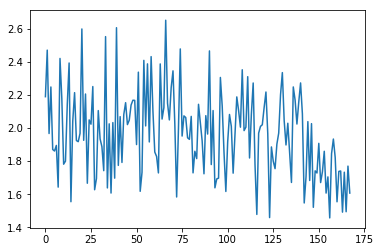

In [260]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

model = RandomForestRegressor()

model_tester.test(model, loss_func=mean_absolute_error)

print(np.mean(model_tester.loss_data))
plt.plot(model_tester.loss_data)
plt.show()

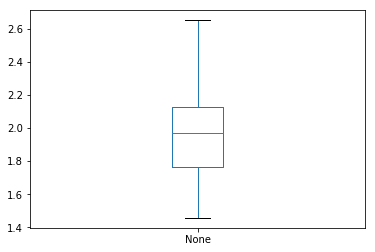

In [261]:
s = pd.Series(model_tester.loss_data)
s.plot('box')

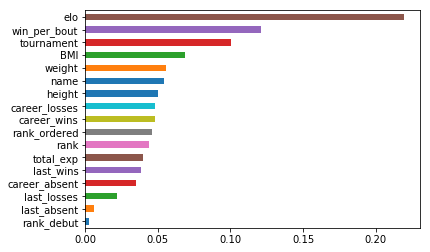

In [262]:
pd.Series(model.feature_importances_, index=model_tester._data.columns).sort_values().plot.barh()

In [315]:
g = [x[1] for x in banzuke_history.groupby('tournament')]
split = int(np.round(len(g) * 0.7))

training_data = pd.concat(g[:split])
testing_data = pd.concat(g[split:])

training_data.shape[0], testing_data.shape[0]

x_train = training_data.drop('wins', axis=1).values
x_test = testing_data.drop('wins', axis=1).values

y_train = training_data.wins.values
y_test = testing_data.wins.values

print(x_train.shape, y_train.shape)

(4650, 17) (4650,)


In [339]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import keras
keras.backend.clear_session()

n_features = x_train.shape[1]

learning_rate = 0.001
batch_size = 128
n_epochs = 20

model = keras.Sequential()
model.add(keras.layers.Dense(128, input_shape=(n_features,), activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer=tf.train.AdamOptimizer(learning_rate),
              loss='mean_absolute_error')

model.summary()
    
with tf.Session() as sess:
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size,
                  validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
Train on 4650 samples, validate on 2086 samples
Epoch 1/20
4650/4650 [==============================]4650/4650 [==============================] - 0s 63us/step - loss: 4.6501 - val_loss: 3.0230

Epoch 2/20
4650/4650 [==============================]4650/4650 [============